## Acquiring the data

In [1]:

import pandas as pd
import glob

#Adding relative path name to data variable. Dataset suffix is data when it's available

for i in glob.glob('../data/data*.csv'):
    data = i
    
#Rows skipped to avoid additional cleaning, dates parsed and date used as the index

MM = pd.read_csv(data, skiprows=[1, 483], header= 0, 
                 na_values=0, parse_dates=['Payouts Payout Currency'], 
                 index_col='Payouts Payout Currency').rename_axis(None)

In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [13]:
#This function sets the beginning of the time series based on first 3 consecutives weeks without FX MM
def series_begins(x):
    nan_index = x.index[x.isnull()]
    for i in range(0,len(nan_index)):
        upper = i + 2
        difference = nan_index[i] - nan_index[(upper)]
        if difference.days == 14:
            return nan_index[i]


In [37]:
MM['KRW'].loc[series_ends(MM['KRW']):].index[MM['KRW'].loc[series_ends(MM['KRW']):].isnull()]

DatetimeIndex(['2020-01-27', '2019-12-30', '2019-12-23', '2019-12-16',
               '2019-12-09', '2019-12-02', '2019-11-25', '2019-11-18',
               '2019-11-11', '2019-11-04',
               ...
               '2011-03-07', '2011-02-28', '2011-02-21', '2011-02-14',
               '2011-02-07', '2011-01-31', '2011-01-24', '2011-01-17',
               '2011-01-10', '2011-01-03'],
              dtype='datetime64[ns]', length=471, freq=None)

In [15]:
#This function sets the end of the time series based on last 2 consecutives weeks with FX MM
def series_ends(x):
    notnan_index = x.index[x.notna()]
    for i in range(0,len(notnan_index)):
        notnan_upper = i + 1
        notnan_difference = notnan_index[i] - notnan_index[(notnan_upper)]
        if notnan_difference.days == 7:
            return notnan_index[i]

In [13]:
def series_ends_begins(x):
    ends_begins = []
    notnan_index = x.index[x.notna()]
    for i in range(0,len(notnan_index)):
        notnan_upper = i + 1
        notnan_difference = notnan_index[i] - notnan_index[(notnan_upper)]
        if notnan_difference.days == 7:
            ends_begins.append(notnan_index[i])
            nan_index = x.loc[ends_begins[0]:].index[x.loc[ends_begins[0]:].isnull()]
            for i in range(0,len(nan_index)):
                upper = i + 2
                difference = nan_index[i] - nan_index[(upper)]
                if difference.days == 14:
                    ends_begins.append(nan_index[i])
                    return ends_begins
                
                
type(series_ends_begins(MM['GBP']))

list

In [19]:
"""
This function lists the end, based on last 2 consecutives weeks with FX MM
and the start, based on on first 3 consecutives weeks without FX MM, of the timeseries.
"""


def series_end_start(x):
    end_start = [0,0]
    notnan_index = x.index[x.notna()]
    for i in range(0,len(notnan_index)):
        notnan_upper = i + 1
        notnan_difference = notnan_index[i] - notnan_index[(notnan_upper)]
        if notnan_difference.days == 7:
            end_start[0] = notnan_index[i]
            nan_index = x.loc[end_start[0]:].index[x.loc[end_start[0]:].isnull()]
            for i in range(0,len(nan_index)):
                upper = i + 2
                difference = nan_index[i] - nan_index[(upper)]
                if difference.days == 14:
                    end_start[1] = nan_index[i]
                    return end_start

In [83]:
series_end_start(MM['PEN'])

In [44]:
series_ends_begins(MM['KRW'])

[Timestamp('2020-02-10 00:00:00'), Timestamp('2019-12-30 00:00:00')]

In [42]:
series = [0,0]
series[1] = 1
series

[0, 1]

In [ ]:
#Beginning dates are passed on a dictionary per feature in the data set

dict_series_begings = {i:series_begins(MM[i]) for i in MM.columns}

In [23]:
#Series end and start dates are passed on to dictionary

dict_series_end_start = {i:series_end_start(MM[i]) for i in MM.columns}

In [33]:
MM.loc[dict_series_end_start['USD'][0]:dict_series_end_start['USD'][1],'USD'].iloc[:-1]

2020-03-16    4.192343e+06
2020-03-09    1.234588e+07
2020-03-02    1.310827e+07
2020-02-24    1.597301e+07
2020-02-17    1.453787e+07
                  ...     
2011-04-11    1.700000e+03
2011-04-04             NaN
2011-03-28             NaN
2011-03-21    5.000000e+01
2011-03-14    9.900000e+01
Name: USD, Length: 471, dtype: float64

In [81]:
#The function creates a data frame bounded by the end and start of the series

def get_df(x):
    try:
        series = MM.loc[dict_series_end_start[x][0]:dict_series_end_start[x][1],x].iloc[:-1].fillna(0)
        df_output = series.reset_index().rename({'index':'ds', x:'y'}, axis=1)
        return df_output
    except:
        return print(f"There isn't enough historic data to predict {x} volumes or {x} is not a valid market.")

In [80]:
get_df('GUA')

There isn't enough historic data to predict GUA volumes or GUA is not a valid market


In [75]:
from matplotlib import pyplot as plt
from fbprophet import Prophet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


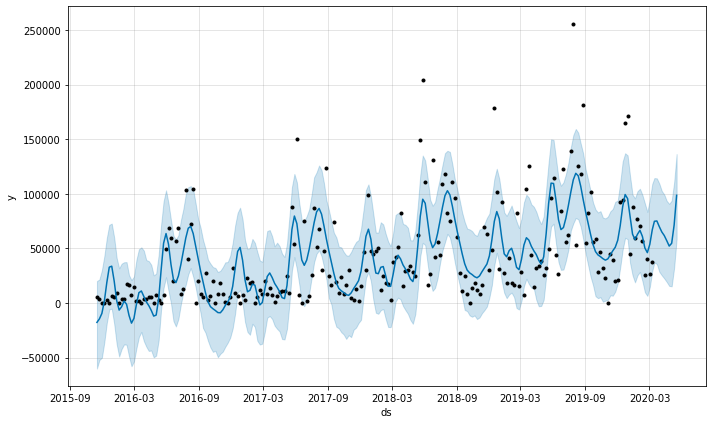

In [86]:
baseline = get_df('AED')
m = Prophet()

m.fit(baseline)
futures = m.make_future_dataframe(periods=10, freq='W')
futures.tail()
fcst = m.predict(futures)
fig = m.plot(fcst)

In [ ]:
MM.apply(lambda x: series_begins(x['AUD']), axis=1)

In [ ]:
MM.apply(lambda x: series_begins(x['AUD']), axis=1)

## Cleaning Data

In [ ]:
MM.isnull().sum().sort_values()

In [ ]:
MM['USD'].sum()